In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import set_plotting_style, get_chunking, make_df, hist2d_dask, query_dis
import utils

from yahist import Hist1D, Hist2D


set_plotting_style()

Clone https://github.com/aminnj/daskucsd into this directory and follow the instructions to set it up (namely, need a tarball to send the conda environment to HTCondor worker nodes)

In [4]:
use_dask = False

In [5]:
if use_dask:
    from dask.distributed import Client
    import dask.dataframe as dd
    import dask.array as da
    from dask import delayed
    from daskucsd.condor_utils import make_htcondor_cluster

In [6]:
cluster = None
if use_dask:
    cluster = make_htcondor_cluster(local=False, dashboard_address=13345,memory="4GB")
    cluster.scale(15)
cluster

Make dask client. Also manually port forward the `dashboard_address` above to your localhost (see instuctions in the `aminnj/daskucsd` repo). Then visit it in the browser to see the worker statuses while running this notebook.

In [7]:
client = None
if use_dask:
    client = Client(cluster)
client

Figure out which sites have which datasets. Pick something local to speed things up.

In [8]:
use_central = True

In [9]:
%%time

if use_central:
    dataset = "/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM"
    lines = !dasgoclient -query='file dataset={dataset}' -json
    js = json.loads("".join(lines))
    df = pd.DataFrame([dict(
        sizeGB=f["file"][0]["size"]/1024**3,
        nevents=f["file"][0]["nevents"],
        name=f["file"][0]["name"],
    ) for f in js])
    fnames = tuple(df["name"])
    print(f"{len(df)} files, {df.nevents.sum()} events")
else:
    fnames = glob.glob("/hadoop/cms/store/user/phchang/nanoaod/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/*.root")
    nevents = sum([uproot.numentries(fname, "Events") for fname in fnames])
    print(f"{len(fnames)} files, {nevents} events")

12 files, 11530510 events
CPU times: user 8 ms, sys: 12 ms, total: 20 ms
Wall time: 1.68 s


Make a function that takes information about a "chunk": filename and start/stop entry number. The function returns a flat pandas DataFrame. In this case, we read muon 4-momenta and MET, and store MET, dimuon masses for events with exactly two muons. We run the function on a small chunk to test it.

In [10]:
def func(fname, entrystart, entrystop):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_mass","MET_pt"],
                    outputtype=dict,namedecode="ascii",
                    entrystart=entrystart,entrystop=entrystop)
    sel = (arrs["Muon_pt"].counts >= 2)
    df = pd.DataFrame()
    TLVA = uproot_methods.TLorentzVectorArray
    mus = TLVA.from_ptetaphim(
        arrs["Muon_pt"][sel],
        arrs["Muon_eta"][sel],
        arrs["Muon_phi"][sel],
        arrs["Muon_mass"][sel],
    )
    mass = (mus[:,0]+mus[:,1]).mass
    df["dimuon_mass"] = mass
    df["MET_pt"] = arrs["MET_pt"][sel]
    return df

testfname = fnames[0].replace("/store/","root://cmsxrootd.fnal.gov//store/")
func(testfname, 0, 10000)

,dimuon_mass,MET_pt
0,89.262779,11.192041
1,92.878616,44.028748
2,91.561005,14.792266
3,91.243340,13.890943
4,93.040024,67.413521
...,...,...
2557,92.248474,30.783525
2558,91.448982,5.925523
2559,192.114288,19.874645
2560,89.099884,6.147094


Run over the full set of files and make a dask DataFrame, passing in our custom `func`, and persisting it so it stays in memory.

In [11]:
ddf = make_df(
    fnames[:3],
    func = func,
    persist = True,
    xrootd = True,
    chunksize = 250e3,
    use_dask = use_dask,
    npartitions=len(fnames)//3,
)

In [16]:
print(ddf.memory_usage().sum()*1e-6)
ddf.head()

4.37432


,MET_pt,dimuon_mass
0,11.192041,89.262779
1,44.028748,92.878616
2,14.792266,91.561005
3,13.890943,91.243340
4,67.413521,93.040024


The first time we make a histogram will be slow because at this point, the dask DataFrame is still being created/persisted. As the chunks are computed, the histogram is calculated until they are all done and summed together. Thus, this cell will block.

2500061.0 events in 15.57s @ 0.16MHz


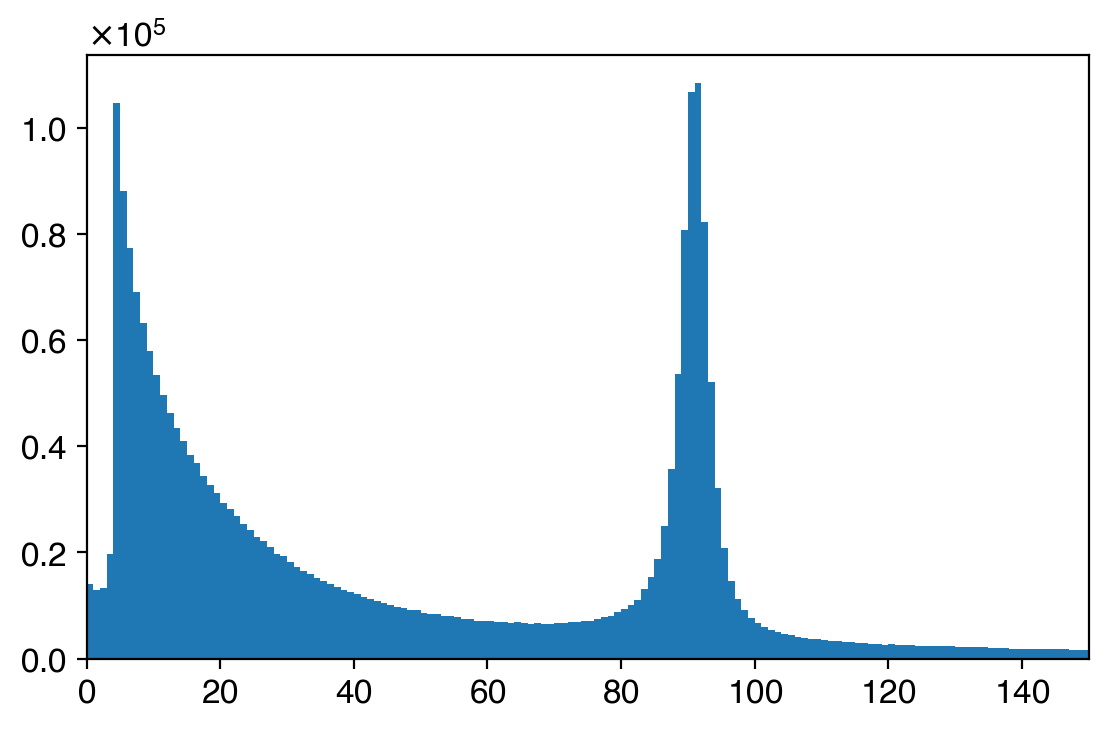

In [66]:
t0 = time.time()
counts, edges = da.histogram(ddf["dimuon_mass"], range=[0,150], bins=150)
h = Hist1D.from_bincounts(counts.compute(), edges)
t1 = time.time()
print(f"{h.integral} events in {t1-t0:.2f}s @ {h.integral/(t1-t0)*1e-6:.2f}MHz")
h.plot()

The second run will be super fast because now the dask DataFrame is fully in memory.

2609233.0 events in 0.13s @ 20.18MHz


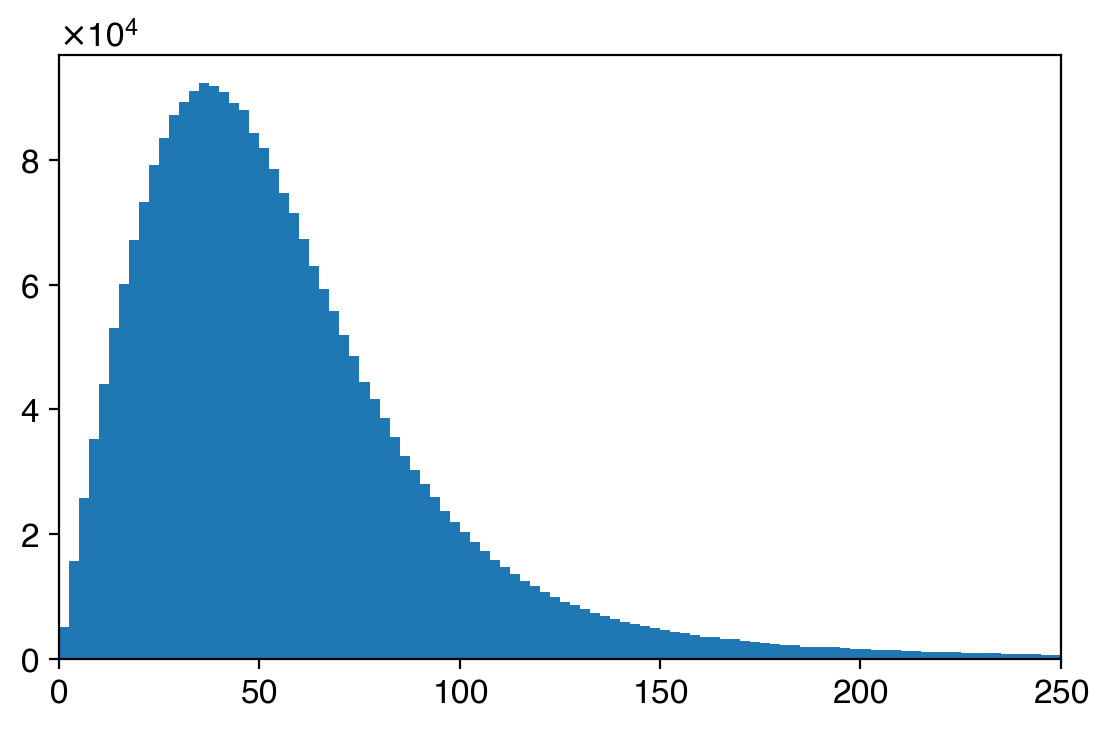

In [67]:
t0 = time.time()
counts, edges = da.histogram(ddf["MET_pt"], range=[0,250], bins=100)
h = Hist1D.from_bincounts(counts.compute(), edges)
t1 = time.time()
print(f"{h.integral} events in {t1-t0:.2f}s @ {h.integral/(t1-t0)*1e-6:.2f}MHz")
h.plot()

How much memory is the dask DataFrame occupying?

In [68]:
print(f"Memory usage: {1e-6*ddf.memory_usage().compute().sum():.2f}MB")

Memory usage: 42.03MB
